## Instalar bibliotecas necesarias

In [1]:
!pip install torch                    # Install the PyTorch library for deep learning.
!pip install pandas                   # Install the Pandas library for data manipulation.
!pip install scikit-learn             # Install scikit-learn for machine learning tasks.

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torchvision.io import read_image
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader,ConcatDataset
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch import optim
import datetime
from sklearn.preprocessing import StandardScaler

## Acceder a drive

In [3]:
from google.colab import drive

# Montar Google Drive en /content/drive
drive.mount('/content/drive')

# Listar archivos en el directorio raíz de Google Drive
!ls '/content/drive/MyDrive/Dataset/Mosaico'

Mounted at /content/drive
dataset.csv  Imagenes  test.csv  train.csv


In [4]:
# --> Definir si viene desde local o drive

ruta = '/content/drive/MyDrive/Dataset/Mosaico/'
# ruta = '../Dataset/Mosaico/'

## Lectura de dataset train

In [5]:
train = pd.read_csv(f'{ruta}train.csv')
train.head()

,bathrooms,bedrooms,area,zipcode,mosaic_image,price
0,2.0,4,7841,60016,78.png,299000
1,2.5,3,3233,62234,70.png,259000
2,1.0,2,1110,94501,204.png,649000
3,3.0,4,2256,62214,72.png,144900
4,2.0,2,2036,92276,287.png,175000


## Clases y funciones auxiliares

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Constructor de la clase que inicializa el dataset personalizado.
        df: DataFrame que contiene los datos (rutas de las imágenes y características numéricas).
        transform: Transformaciones opcionales que se aplicarán a las imágenes (si se proporciona).
        """
        self.df = df  # Guardar el DataFrame que contiene las rutas de imágenes y las características numéricas.
        self.transform = transform  # Almacenar las transformaciones opcionales para las imágenes.

        # Seleccionar las columnas que contienen las características numéricas que deseas estandarizar.
        self.numeric_features = ['bedrooms', 'bathrooms', 'area', 'zipcode']

        # Inicializar el estandarizador de sklearn (StandardScaler) y ajustarlo a las características numéricas.
        # Esto normaliza las características para que tengan media 0 y desviación estándar 1.
        self.scaler = StandardScaler()

        # Aplicar el estandarizador a las columnas de características numéricas y actualizar el DataFrame.
        # Las características numéricas se estandarizan y reemplazan en el DataFrame original.
        self.df[self.numeric_features] = self.scaler.fit_transform(self.df[self.numeric_features])

    def __len__(self):
        """
        Método que devuelve la longitud del dataset, es decir, el número de muestras en el DataFrame.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Método que obtiene una muestra del dataset en el índice `idx`.
        Este método es necesario para que el DataLoader pueda iterar sobre el dataset.
        idx: Índice de la muestra a recuperar.

        Devuelve:
        - La imagen procesada (como un tensor).
        - Las características numéricas estandarizadas (como un tensor).
        - El valor objetivo (precio), también convertido a tensor.
        """
        # Obtener la ruta de la imagen correspondiente al índice dado.
        img_path = self.df.loc[idx, 'mosaic_image']

        # Leer la imagen desde el disco utilizando torchvision.io.read_image.
        # Convierte la imagen en un tensor y ajusta su tipo de dato a flotante (float32).
        mosaic_image = read_image(f"{ruta}Imagenes/{img_path}").float()

        # Obtener los valores de las características numéricas para la muestra actual.
        # Convertir estos valores en tensores de tipo float32.
        bathrooms = torch.tensor(self.df.loc[idx, 'bathrooms'], dtype=torch.float32)
        bedrooms = torch.tensor(self.df.loc[idx, 'bedrooms'], dtype=torch.float32)
        area = torch.tensor(self.df.loc[idx, 'area'], dtype=torch.float32)
        zipcode = torch.tensor(self.df.loc[idx, 'zipcode'], dtype=torch.float32)
        price = torch.tensor(self.df.loc[idx, 'price'], dtype=torch.float32)  # Precio como el valor objetivo.

        # Aplicar las transformaciones a la imagen si se proporcionaron en el constructor.
        if self.transform:
            mosaic_image = self.transform(mosaic_image)

        # Concatenar las características numéricas (bathrooms, bedrooms, area, zipcode) en un único tensor.
        # Utilizar torch.hstack para concatenar los tensores a lo largo del eje horizontal.
        numeric_features = torch.hstack((bathrooms, bedrooms, area, zipcode))

        # Devolver la imagen procesada, las características numéricas estandarizadas y el precio objetivo.
        return mosaic_image, numeric_features, price


In [7]:
import matplotlib.pyplot as plt
import torch

# Función para deshacer la normalización (inverso de transforms.Normalize)
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1) # Ajustar la media a la forma del tensor
    std = torch.tensor(std).view(3, 1, 1)   # Ajustar la desviación estándar a la forma del tensor
    return tensor * std + mean

# Función para mostrar una imagen
def show_image(image_tensor, title=None, apply_desnormalize=False):
    # Deshacer la normalización
    if apply_desnormalize:
        image_tensor = denormalize(image_tensor, mean=(58.0583, 55.1679, 52.9831), std=(85.9875, 82.3628, 80.8718))

    # Asegurarse de que los valores de los píxeles estén entre 0 y 255
    image_tensor = torch.clamp(image_tensor, 0, 255)

    # Convertir el tensor a numpy
    image = image_tensor.permute(1, 2, 0).cpu().numpy()  # Cambia las dimensiones de (C, H, W) a (H, W, C)

    # Mostrar la imagen
    plt.imshow(image.astype('uint8'))       # Convertir los valores a uint8 para que matplotlib pueda mostrarlos correctamente
    if title:
        plt.title(title)
    plt.axis('off')                         # Quitar los ejes
    plt.show()


In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.image_features_ = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),   # 400x400
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # 200x200
            nn.Dropout(),

            nn.Conv2d(16, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # 100x100
            nn.Dropout(),

            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # 50x50

            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # 25x25
        )
        self.numeric_features_ = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64, 64*3),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64*3, 64*3*3),
            nn.ReLU(inplace=True),
        )
        self.combined_features_ = nn.Sequential(
            nn.Linear(37440, 64*3*3*2*2),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(64*3*3*2*2, 64*3*3*2),
            nn.ReLU(inplace=True),

            nn.Linear(64*3*3*2, 64),
            nn.Linear(64, 1),
        )

    def forward(self, x,y):
        x = self.image_features_(x)
        # print(x.shape)
        x=x.view(-1, 64*24*24)
        # print(x.shape)
        y=self.numeric_features_(y)
        # print(y.shape)
        z=torch.cat((x,y),1)
        # print(z.shape)
        z=self.combined_features_(z)
        return z.squeeze(1)

In [9]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

In [10]:
def test_loop(dataloader, model, loss_fn, device):
    """
    Función para realizar un bucle de prueba en el conjunto de datos de prueba.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    total_error = 0

    with torch.no_grad():
        for batch_idx, (imgs, numeric_features, price) in enumerate(dataloader):
            # Mandar datos al dispositivo
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            price = price.to(device)

            # Predecir
            pred = model(imgs, numeric_features)

            # Calcular pérdida
            batch_loss = loss_fn(pred, price).item()
            test_loss += batch_loss
            total_error += torch.abs(pred - price).sum().item()

            # Imprimir la pérdida de cada batch
            print(f"Batch {batch_idx+1}/{num_batches}, Batch Loss: {batch_loss:.4f}")

    # Calcular pérdida y error promedio
    test_loss /= num_batches
    avg_error = total_error / size

    print(f"Test Error: \n Avg loss: {test_loss:.6f}, Avg error: {avg_error:.6f} \n")
    return test_loss

In [11]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, device):
    """
    Función para realizar el bucle de entrenamiento.
    """
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        model.train()

        for batch_idx, (imgs, numeric_features, price) in enumerate(train_loader):
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            price = price.to(device)

            output = model(imgs, numeric_features)

            loss = loss_fn(output, price)

            # L2 Regularization
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

            # Imprimir la pérdida en cada batch
            print(f"Epoch {epoch}, Batch {batch_idx+1}/{len(train_loader)}, Batch Loss: {loss.item():.4f}")

        loss_train /= len(train_loader)
        train_losses.append(loss_train)

        model.eval()
        val_loss = test_loop(dataloader=val_loader, model=model, loss_fn=loss_fn, device=device)
        val_losses.append(val_loss)

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Average Training loss {}'.format(datetime.datetime.now(), epoch, loss_train))

    return train_losses, val_losses

## Ejecución de entrenamiento

In [12]:
# --> Aumentar el tamaño de las muestras de entrenamiento y validación.

# Dataset sin transformaciones
data1 = CustomImageDataset(df=train)

# Dataset con transformación de normalización
data2 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.Normalize(
        (58.0583, 55.1679, 52.9831),                    # Media para normalizar los canales RGB
        (85.9875, 82.3628, 80.8718)                     # Desviación estándar para normalizar
    )
]))

# Dataset con desplazamiento de canales y normalización
data3 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.Lambda(lambda img: img[[2, 1, 0], :, :]),    # Cambiar los canales RGB a BGR
    transforms.Normalize(
        (58.0583, 55.1679, 52.9831),                        # Media para normalizar los canales RGB
        (85.9875, 82.3628, 80.8718)                         # Desviación estándar para normalizar
    )
]))

# Dataset con transformación de volteo horizontal y normalización
data4 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),            # Girar horizontalmente con una probabilidad del 50%
    transforms.Normalize(
        (58.0583, 55.1679, 52.9831),                    # Media para normalizar los canales RGB
        (85.9875, 82.3628, 80.8718)                     # Desviación estándar para normalizar
    )
]))

# Dataset con transformación de volteo vertical y normalización
data5 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),              # Girar verticalmente con una probabilidad del 50%
    transforms.Normalize(
        (58.0583, 55.1679, 52.9831),                    # Media para normalizar los canales RGB
        (85.9875, 82.3628, 80.8718)                     # Desviación estándar para normalizar
    )
]))

# Dataset con desenfoque gaussiano y normalización
data6 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.Normalize(
        (58.0583, 55.1679, 52.9831),                    # Media para normalizar los canales RGB
        (85.9875, 82.3628, 80.8718)                     # Desviación estándar para normalizar
    )
]))



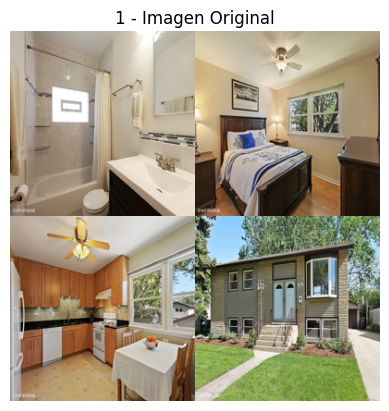

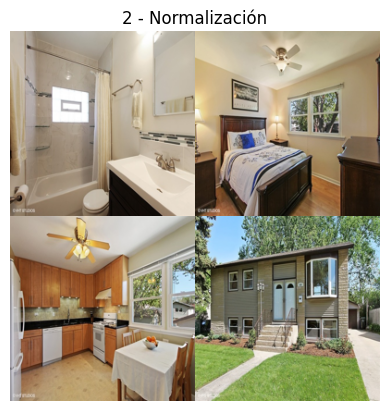

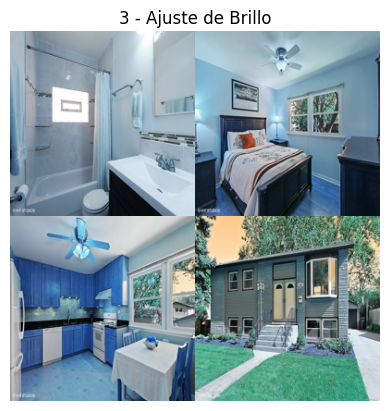

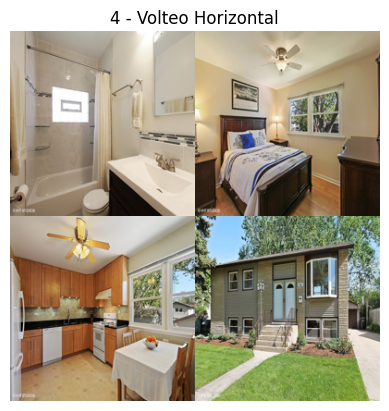

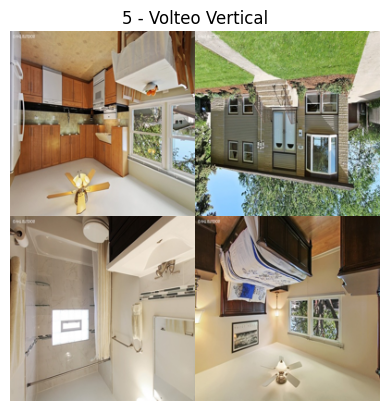

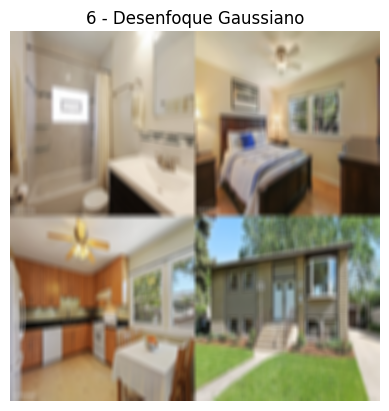

In [13]:
# --> Ver las imágenes de entrenamiento con diferentes transformaciones.

lista_titulos = [
    'Imagen Original', 'Normalización', 'Ajuste de Brillo',
    'Volteo Horizontal', 'Volteo Vertical', 'Desenfoque Gaussiano'
    ]

# Visualizar la primera imagen de cada conjunto de datos
datasets = [data1, data2, data3, data4, data5, data6]

# Iterar
for i, dataset in enumerate(datasets, 1):
    # Obtener la primera muestra del conjunto de datos (imagen, características numéricas, precio)
    image, _, _ = dataset[0]

    # Mostrar la imagen
    if i == 1:
        show_image(image, title=f"{i} - {lista_titulos[i-1]}")
    else:
        show_image(image, title=f"{i} - {lista_titulos[i-1]}", apply_desnormalize=True)

In [14]:
# --> Combinar los conjuntos de datos en un solo conjunto de datos
conjunto_datos = ConcatDataset((data1, data2, data3, data4, data5, data6))

valor_train = int(0.9 * len(conjunto_datos))
valor_val = len(conjunto_datos) - valor_train

print(f"Train: {valor_train} Val: {valor_val}")

Train: 2597 Val: 289


In [15]:
# --> Dividir el conjunto de datos en conjuntos de entrenamiento y validación
train_data,val_data=torch.utils.data.random_split(ConcatDataset((data1, data2, data3, data4, data5, data6)), [valor_train, valor_val])

# --> Eliminar las variables que ya no se necesitan
del data1, data2, data3, data4, data5, data6

In [16]:
# --> Crear los dataloaders
batch_size_train = 53
batch_size_val = 17
# batch_size=64

train_dataloader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size_val, shuffle=False)

print(f"Muestras de train: {len(train_data)} - Baches {len(train_dataloader)}")
print(f"Muestras de test: {len(val_data)} - Baches {len(val_dataloader)}")

Muestras de train: 2597 - Baches 49
Muestras de test: 289 - Baches 17


In [17]:
# --> Definir dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Dispositivo: {device}")

# --> Definir modelo
model = NeuralNetwork().to(device)              # Modelo de red neuronal mandarlo al dispositivo (GPU)

# --> Definir optimizador y la función de pérdida
optimizer=optim.Adam(model.parameters(),1e-3)   # Adam optimizer para optimización
# loss_fn=nn.MSELoss()                          # Mean Squared Error Loss para regresión
loss_fn = RMSELoss()                            # RMSE Loss para regresión

Dispositivo: cuda


In [18]:
# Entrenamiento
n_epochs = 165
train_losses, val_losses = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    device=device
)

Se han truncado las últimas 5000 líneas del flujo de salida.
Epoch 93, Batch 45/49, Batch Loss: 93607.8047
Epoch 93, Batch 46/49, Batch Loss: 96929.8516
Epoch 93, Batch 47/49, Batch Loss: 72422.7656
Epoch 93, Batch 48/49, Batch Loss: 82656.6953
Epoch 93, Batch 49/49, Batch Loss: 66725.5000
Batch 1/17, Batch Loss: 182915.7656
Batch 2/17, Batch Loss: 95331.7344
Batch 3/17, Batch Loss: 170344.5781
Batch 4/17, Batch Loss: 126033.5703
Batch 5/17, Batch Loss: 1376023.6250
Batch 6/17, Batch Loss: 95927.9375
Batch 7/17, Batch Loss: 166744.5469
Batch 8/17, Batch Loss: 79454.9219
Batch 9/17, Batch Loss: 128275.5156
Batch 10/17, Batch Loss: 77169.3047
Batch 11/17, Batch Loss: 135744.0781
Batch 12/17, Batch Loss: 327602.7812
Batch 13/17, Batch Loss: 113114.3672
Batch 14/17, Batch Loss: 211733.5000
Batch 15/17, Batch Loss: 187022.0781
Batch 16/17, Batch Loss: 107046.1641
Batch 17/17, Batch Loss: 149075.3594
Test Error: 
 Avg loss: 219385.872243, Avg error: 110355.779844 

Epoch 94, Batch 1/49, Batc

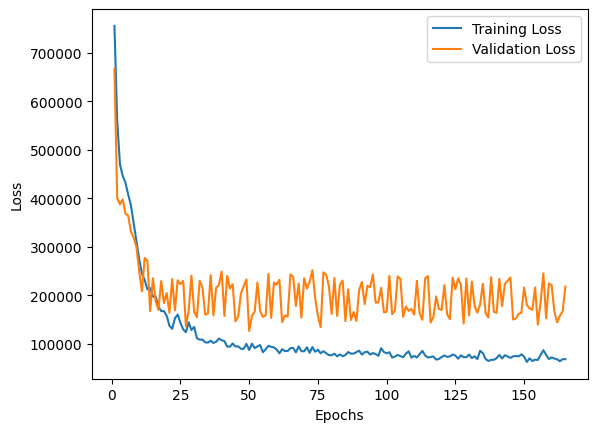

In [19]:
import matplotlib.pyplot as plt

# Graficar las pérdidas
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Probar modelo

In [20]:
# Importar dataset
test = pd.read_csv(f'{ruta}test.csv')
test.head()

,bathrooms,bedrooms,area,zipcode,mosaic_image,price
0,2.5,3,1915,92021,117.png,485000
1,2.5,3,2248,92677,132.png,1199000
2,1.0,3,1132,96019,154.png,170000
3,4.0,6,3375,92880,245.png,538000
4,2.5,3,2733,91901,84.png,689000


In [23]:
len(test)

54

In [21]:
# Crear dataset
test_data = CustomImageDataset(df=test)

In [24]:
# Crear dataloader
test_loader = DataLoader(test_data, batch_size=9, shuffle=False)

In [25]:
len(test_loader)

6

In [26]:
# Predecir precios de casa

def predict(model, test_loader, device):
    model.eval()  # Poner el modelo en modo evaluación
    predictions = []
    actuals = []

    with torch.no_grad():  # Deshabilitar el cálculo de gradientes
        for batch_idx, (imgs, numeric_features, target) in enumerate(test_loader):
            # Mover los datos a la GPU si está disponible
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            target = target.to(device)

            # Forward pass: obtener las predicciones
            output = model(imgs, numeric_features)

            # Almacenar las predicciones y los valores reales (en CPU para facilidad)
            predictions.append(output.cpu().numpy())
            actuals.append(target.cpu().numpy())

    # Convertir las listas de predicciones y reales en arrays de NumPy
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    return predictions, actuals

In [27]:
# Llamar a la función de predicción
predictions, actuals = predict(model, test_loader, device)

# Mostrar algunas predicciones junto con los valores reales
for i in range(10):  # Mostrar los primeros 10 ejemplos
    print(f"Predicción: {predictions[i]}, Valor real: {actuals[i]}")


Predicción: 331528.125, Valor real: 485000.0
Predicción: 431564.46875, Valor real: 1199000.0
Predicción: 261727.875, Valor real: 170000.0
Predicción: 500365.5625, Valor real: 538000.0
Predicción: 480437.9375, Valor real: 689000.0
Predicción: 232088.8125, Valor real: 118900.0
Predicción: 470344.5625, Valor real: 799000.0
Predicción: 599149.75, Valor real: 895000.0
Predicción: 451134.8125, Valor real: 599000.0
Predicción: 270431.5625, Valor real: 535000.0


In [28]:
# Evaluacion

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"RMSE en el conjunto de prueba: {rmse:.4f}")

# Calcular MAE
mae = mean_absolute_error(actuals, predictions)
print(f"MAE en el conjunto de prueba: {mae:.4f}")


RMSE en el conjunto de prueba: 343795.0938
MAE en el conjunto de prueba: 223937.0156


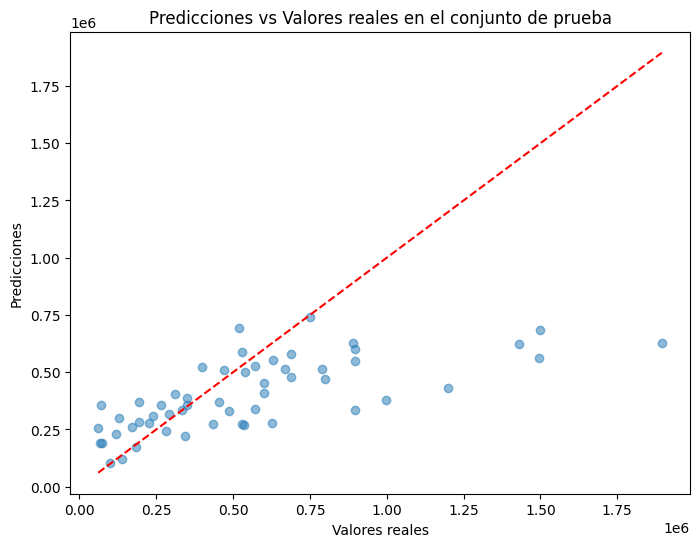

In [29]:
import matplotlib.pyplot as plt

# Graficar las predicciones vs los valores reales
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # Línea de igualdad (predicción = realidad)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales en el conjunto de prueba')
plt.show()
